<div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 40px; margin-top: 0;">
    <div style="flex: 0 0 auto; margin-left: 0; margin-bottom: 0; margin-top: 0;">
        <img src="./pics/UCSD Logo.png" alt="UCSD Logo" style="width: 179px; margin-bottom: 0px; margin-top: 20px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/LANL-logo.png" alt="LANL Logo" style="width: 200px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/prowess.png" alt="Prowess Logo" style="width: 200px; margin-bottom: 0px;">
    </div>
    <div style="flex: 0 0 auto; margin-left: auto; margin-bottom: 0; margin-top: 20px;">
        <img src="./pics/wildfire.png" alt="WildFire Logo" width="100"/>
    </div>
</div>

<h1 style="text-align: center; font-size: 48px; margin-top: 0;">Fire-Ready Forests Data Challenge</h1>

# Update treelist with ALS

This notebook describes how to use the tree locations derived from ALS to put the trees in the correct location and predict the trees based on a given tree list using a simple random forest model

Your task for this will be to replicate this code for each of the different sites of data that we have.

In [1]:
# import packages

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
! wget https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/Raw%20ALS%20and%20Detected%20Trees/ALS_treetops.csv

! wget https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/FF%20Tree%20List/FF_treelist_all.csv

! wget https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/fia_data/REF_SPECIES.csv


In [2]:
# Load the detected trees from the ALS data and the fast fuels treelist

ALS_treetops = pd.read_csv('ALS_treetops.csv')
FF_treelist = pd.read_csv('FF_treelist_all.csv')
fia_ref_species_table = pd.read_csv('REF_SPECIES.csv')

In [3]:
ALS_treetops.head()

,treeID,height_m,geometry,site_name,X_4326,Y_4326
0,1,24.063305,POINT (-120.2920154862352 39.45939011042483),ind,-120.292015,39.459390
1,2,12.609000,POINT (-120.2921493614317 39.45938422117258),ind,-120.292149,39.459384
2,3,14.492822,POINT (-120.2922630919081 39.45937335805888),ind,-120.292263,39.459373
3,4,13.221030,POINT (-120.2923480566636 39.45935506811125),ind,-120.292348,39.459355
4,5,22.964533,POINT (-120.2921768821307 39.45934882765053),ind,-120.292177,39.459349


In [4]:
FF_treelist.head()

,SPCD,DIA,HT,STATUSCD,CBH,CR,X,Y,geometry,site_name,X_4326,Y_4326
0,116,75.946,32.9184,1,23.04288,2.043188,-2049026.395,2.089361e+06,POINT (-120.2952849457103 39.45591467737306),ind,-120.295285,39.455915
1,108,45.974,16.1544,1,4.84632,2.339576,-2048975.022,2.089360e+06,POINT (-120.2946995468131 39.45602344723524),ind,-120.294699,39.456023
2,108,45.974,16.1544,1,4.84632,2.339576,-2048980.637,2.089337e+06,POINT (-120.2946958052986 39.45581438459021),ind,-120.294696,39.455814
3,15,NaN,NaN,2,NaN,NaN,-2049002.852,2.089341e+06,POINT (-120.2949603351156 39.45580051578337),ind,-120.294960,39.455801
4,108,40.132,17.9832,1,13.48740,0.930155,-2048990.667,2.089373e+06,POINT (-120.2949164838158 39.45610283964217),ind,-120.294916,39.456103


In [5]:
# let's look specifically at Independence Lake
# site_shortname = ['ind', 'SHA', 'SDR', 'win', 'puc', 'tcu']
site_name = 'ind'

In [6]:
ALS_treetops_filter = ALS_treetops[ALS_treetops.site_name == site_name]
FF_treelist_filter = FF_treelist[FF_treelist.site_name == site_name]

# rename the height column for the ALS file
ALS_treetops_filter = ALS_treetops_filter.rename(columns = {'height_m': 'HT'})


#now turn into geodataframe

ALS_treetops_gdf = gpd.GeoDataFrame(ALS_treetops_filter, 
                                    geometry = gpd.points_from_xy(ALS_treetops_filter.X_4326, ALS_treetops_filter.Y_4326), 
                                    crs = 4326)
# treelist = gpd.GeoDataFrame(FF_treelist_filter, 
#                                    geometry = gpd.points_from_xy(FF_treelist_filter.X_4326, FF_treelist_filter.Y_4326), 
#                                    crs = 4326)

treelist = FF_treelist_filter

#first we need to rename one of our variables


The ALS treelist gives us the location and height of the trees, but does not give us all the tree information that we want (including the diameter, species, and crown base height). In this notebook, we will look at how we can use a tree list to predict these tree metrics using a simple random forest model. In this case, we will be using the tree list from the fast fuels algorithm, but it will be your task to modify this notebook to take in another tree list as the training data for the model (for example, the field data tree list).

We will train a different model for each variable that we are interested in predicting. 
This means that we will have a model to predict diameter from height, a second model to predict species from height, and a third model to predict crown base height from total height.

## Diameter from height

Our first random forest model will take in height (HT) as input and produce diameter (DIA) as output.

In [7]:
# Split into training and test sets
independent_variables = ["HT"]
dependent_variable = "DIA"
include_variables = independent_variables + [dependent_variable]
trees_train, trees_test = train_test_split(treelist[include_variables].dropna(), test_size=0.2)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

Training set size: 18317
Test set size: 4580


Model R^2: 0.91
Model RMSE: 5.83 inches


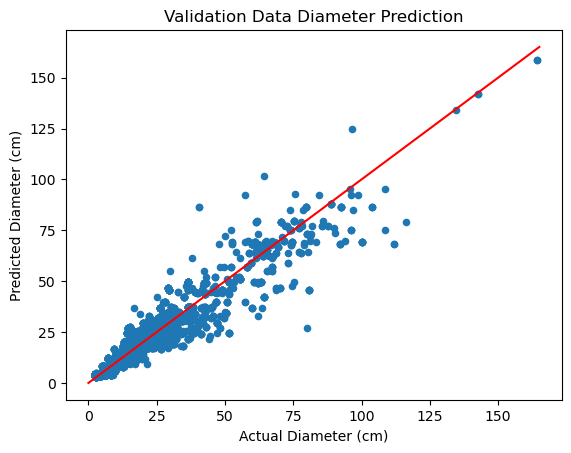

In [8]:
# Train the model
model_ht = RandomForestRegressor()
model_ht.fit(trees_train[independent_variables], trees_train[dependent_variable])

# Predict the model
predicted_dbh_test = model_ht.predict(trees_test[independent_variables])
predicted_dbh = model_ht.predict(ALS_treetops_filter[independent_variables])

# Compute R^2 and RMSE using the test set
print(f"Model R^2: {model_ht.score(trees_test[independent_variables], trees_test[dependent_variable]):.2f}")
print(f"Model RMSE: {((model_ht.predict(trees_test[independent_variables]) - trees_test[dependent_variable])**2).mean()**0.5:.2f} inches")


# Compare the predicted diameter to the actual diameter.
fig, ax = plt.subplots()
trees_test["predicted_diameter"] = predicted_dbh_test
trees_test.plot.scatter(x="DIA", y="predicted_diameter", ax=ax)
upper_dia_limit = max(trees_test["DIA"].max(), trees_test["predicted_diameter"].max()) + 1
ax.plot([0, upper_dia_limit], [0, upper_dia_limit], color='red')
ax.set_xlabel("Actual Diameter (cm)")
ax.set_ylabel("Predicted Diameter (cm)")
ax.set_title("Validation Data Diameter Prediction")
plt.show()

That's pretty good for a simple model! Accuracy decreases as diameter increases, but up to around 30 inches it is quite accurate. It may be worth investigating approaches for outlier detection and removal. For example, maybe we can improve model performance by only considering diameter estimates in a certain range. Consider investigating the diameter range of the validation data to further constrain the problem.

Next, let's use our new model to predict the diameters using the heights we observed from the ALS LIDAR data.

In [9]:
# User our new model to predict the diameter of the trees detected in the ALS data

ALS_treetops_filter["predicted_diameter"] = predicted_dbh

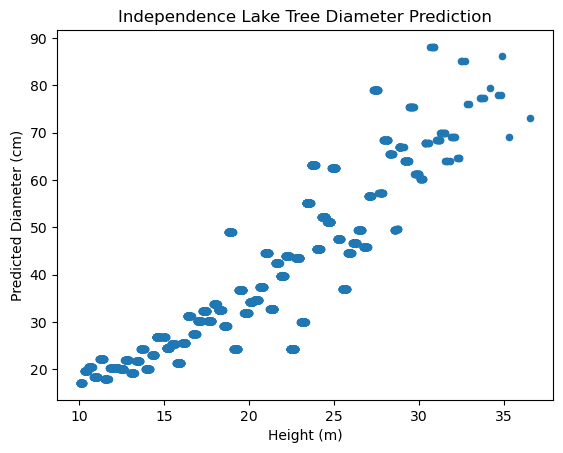

In [10]:
# Plot the predicted diameter
fig, ax = plt.subplots()
ALS_treetops_filter.plot.scatter(x="HT", y="predicted_diameter", ax=ax)
ax.set_xlabel("Height (m)")
ax.set_ylabel("Predicted Diameter (cm)")
ax.set_title("Independence Lake Tree Diameter Prediction")
plt.show()

### SPCD (Species code) from height

Species code, or SPCD, is a numeric identifier for tree species across the United States. Tree species is an enormously important characteristic for making predictions about tree biomass, carbon content, size, and more. Unfortunately, we don't learn tree species from the ALS acquistion data so we want to try and predict it using a model trained on FIA data. In this example, we train a simple random forest classifer to predict trees species based just on the height of the tree. Let's see how well this simple model performs.

In [11]:
# Create a dictionary mapping SPCD to COMMON_NAME
spcd_to_common_name = dict(zip(fia_ref_species_table['SPCD'], fia_ref_species_table['COMMON_NAME']))

In [12]:
# Split into training and test sets
independent_variables = ["HT"]
dependent_variable = "SPCD"
include_variables = independent_variables + [dependent_variable]
trees_train, trees_test = train_test_split(treelist[include_variables].dropna(), test_size=0.2)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

# Train the model
model_spcd = RandomForestClassifier()
model_spcd.fit(trees_train[independent_variables], trees_train[dependent_variable])

# Predict the model
predicted_spcd_test = model_spcd.predict(trees_test[independent_variables])
predicted_spcd = model_spcd.predict(ALS_treetops_filter[independent_variables])


# Evaluate classification accuracy
unique_species = sorted(trees_test[dependent_variable].unique())
species_names = [spcd_to_common_name.get(spcd, f"Unknown ({spcd})") for spcd in unique_species]
report = classification_report(trees_test[dependent_variable], predicted_spcd_test, zero_division=0, target_names=species_names)
print(report)

Training set size: 18317
Test set size: 4580
                    precision    recall  f1-score   support

         white fir       0.44      0.17      0.25       333
         grand fir       0.43      0.08      0.14        37
     subalpine fir       0.00      0.00      0.00       156
California red fir       0.56      0.40      0.46       630
    Shasta red fir       0.34      0.35      0.34        49
     incense-cedar       0.00      0.00      0.00        43
  Engelmann spruce       0.47      0.94      0.62        90
    lodgepole pine       0.59      0.68      0.63      1687
      Jeffrey pine       0.00      0.00      0.00        41
        sugar pine       0.00      0.00      0.00         8
western white pine       0.00      0.00      0.00       114
    ponderosa pine       0.57      0.74      0.64      1210
       Douglas-fir       0.75      0.18      0.29        17
     bitter cherry       0.61      1.00      0.76       165

          accuracy                           0.57    

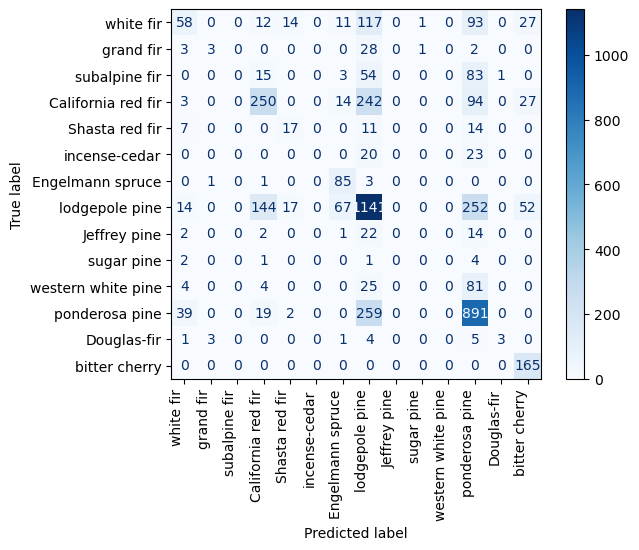

In [13]:
cm = confusion_matrix(trees_test[dependent_variable], predicted_spcd_test)
display = ConfusionMatrixDisplay(cm, display_labels=species_names)
display.plot(cmap='Blues', values_format='d')
plt.xticks(rotation=90, ha='right')
plt.show()

It looks like the confusion matrix has identified some common areas of confusion for our model. 

The model frequently predicts lodgepole pine for different conifer trees including Ponderosa Pine, California red fir, and white fir, among other fir and pine species.

What can we do to our model to improve predictions? Are there additional variables that you can think of that would help with the prediction?


### Crown Base Height (CBH) from Height

Crown base height (CBH), sometimes called live crown base height, is a measurment of how far above the ground the crown of the tree is. You can think of this as if you stood under a tree and stretched and stretched until your fingertips touch leaves or needles. How far you have to stretch (including your Go-Go-Gadget arm extenders) is the crown base height. 

Like species code, this is an important measurement because it tells us things like how likely a fire is to move from the surface into the tree, or how much foliage is in the crown. However, also like species code, we can't learn this from the ALS data and it is a difficult thing to predict. But, let's start simple and train a random forest model to predict crown base height just from the height of the tree.

Training set size: 19610
Test set size: 2179

Model R^2: 0.85
Model RMSE: 1.79 feet


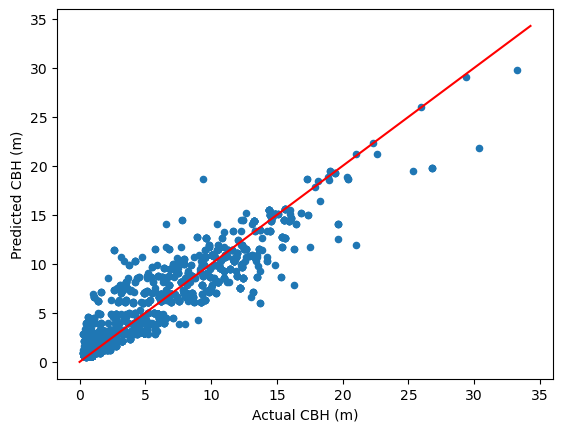

In [15]:
# Split into training and test sets
# treelist["CBH"] = treelist["HT"] * (1 - treelist["CR"] / 100) #use this if CBH isn't included already
independent_variables = "HT"
dependent_variable = "CBH"
include_variables = independent_variables + dependent_variable
trees_train, trees_test = train_test_split(treelist[['HT', 'CBH']].dropna(), test_size=0.1)
print(f"Training set size: {len(trees_train)}")
print(f"Test set size: {len(trees_test)}")

# Train the model
model_cbh = RandomForestRegressor()
model_cbh.fit(trees_train[[independent_variables]], trees_train[dependent_variable])

# predict the model
predicted_cbh_test = model_cbh.predict(trees_test[[independent_variables]])
predicted_cbh = model_cbh.predict(ALS_treetops_filter[[independent_variables]])

# Evaluate model performance
print()
print(f"Model R^2: {model_cbh.score(trees_test[[independent_variables]], trees_test[dependent_variable]):.2f}")
print(f"Model RMSE: {((model_cbh.predict(trees_test[[independent_variables]]) - trees_test[dependent_variable])**2).mean()**0.5:.2f} feet")

# Compare the predicted CBH to the actual CBH.
fig, ax = plt.subplots()
trees_test["predicted_cbh"] = predicted_cbh_test
trees_test.plot.scatter(x="CBH", y="predicted_cbh", ax=ax)
upper_cbh_limit = max(trees_test["CBH"].max(), trees_test["predicted_cbh"].max()) + 1
ax.plot([0, upper_cbh_limit], [0, upper_cbh_limit], color='red')
ax.set_xlabel("Actual CBH (m)")
ax.set_ylabel("Predicted CBH (m)")
plt.show()

Note that live crown base height is often impacted by things like light availability, neighboring trees, and other landscape characteristics. 

In [16]:
# save the predictions for tree metrics as a new treelist
predicted_treelist = pd.DataFrame({'treeID': ALS_treetops_filter.treeID,
                                   'HT': ALS_treetops_filter.HT,
                                   'DIA': predicted_dbh,
                                   'SPCD': predicted_spcd,
                                   'CBH': predicted_cbh,
                                   'X_4326': ALS_treetops_filter.X_4326,
                                   'Y_4326': ALS_treetops_filter.Y_4326,
                                  })

# predicted_treelist.to_csv('predicted_treelist.csv')

In [17]:
predicted_treelist.head()

,treeID,HT,DIA,SPCD,CBH,X_4326,Y_4326
0,1,24.063305,45.487407,108,12.640316,-120.292015,39.459390
1,2,12.609000,20.095697,108,7.066407,-120.292149,39.459384
2,3,14.492822,26.744035,122,8.517069,-120.292263,39.459373
3,4,13.221030,19.248416,122,7.357563,-120.292348,39.459355
4,5,22.964533,43.553572,122,15.068541,-120.292177,39.459349


## Compare your results between the predicted treelist and the field data

Compare your results.

In [ ]:
#download the plot data

! wget -q https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/field_data/01_plot_identification.csv

In [18]:
plots_df = pd.read_csv('01_plot_identification.csv')

plots_df.head()

,inventory_id,site_project,site_project_label,site_name,site_name_label,inventory_pre_post_fire,inventory_pre_post_fire_label,plot_num,plot_blk,inventory_date,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
0,143_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,143,CAFKU_0143_20240721_1,7/21/24,...,100,1,50.0,40.0,4.0,0.0,10.0,1,3.0,Abigail
1,140_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,140,CAFKU_0140_20240721_1,7/21/24,...,100,1,95.0,15.0,2.0,5.0,80.0,1,3.0,Abigail
2,152_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,152,CAFKU_0152_20240721_1,7/21/24,...,100,1,55.0,30.0,5.0,0.0,20.0,1,3.0,Abigail
3,147_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,147,CAFKU_0147_20240720_1,7/20/24,...,100,1,75.0,30.0,15.0,8.0,25.0,1,3.0,Abigail
4,151_pre_SHA_burn3d,burn3d,Burnpro3d,SHA,Shaver Lake (SHA),pre,Prefire,151,CAFKU_0151_20240720_1,7/20/24,...,100,1,75.0,50.0,5.0,2.0,40.0,1,3.0,Abigail


In [19]:
plots_intermediate = []
for srs in np.unique(plots_df.plot_coord_srs):
    plots_subset = plots_df[plots_df.plot_coord_srs == srs]
    plots_subset_gdf = gpd.GeoDataFrame(plots_subset, 
                                   geometry = gpd.points_from_xy(plots_subset.plot_coord_x, plots_subset.plot_coord_y), 
                                   crs = srs)

    #reproject to EPSG 5070
    plots_subset_gdf = plots_subset_gdf.to_crs(5070)
    
    plots_intermediate.append(plots_subset_gdf)

plots_gdf = pd.concat(plots_intermediate)
plots_gdf = plots_gdf.dropna(subset = 'plot_blk')

In [20]:
#buffer the plots to get 1/10 acre plots
import numpy as np

plot_size = 1/10 #acre
acre_to_m2 = 4046.86
plot_size_m2 = plot_size * acre_to_m2
plot_radius = np.sqrt(plot_size_m2/np.pi)

plots_gdf = plots_gdf.set_geometry(plots_gdf.buffer(plot_radius))

In [21]:
# filter the plot using the site name
plots_filtered = plots_gdf[plots_gdf.site_name == site_name]

Text(38.097222222222214, 0.5, 'Y (meters)')

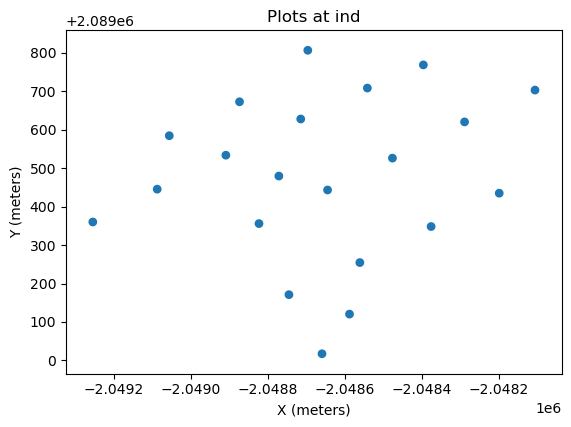

In [22]:
plots_filtered.plot()
plt.title(f'Plots at {site_name}')
plt.xlabel('X (meters)')
plt.ylabel('Y (meters)')

Now we will use spatial join to get the predicted trees for each plot


In [23]:
# first we need to convert the predicted treelist from a dataframe to a geodataframe

predicted_treelist_gdf = gpd.GeoDataFrame(predicted_treelist, 
                                          geometry = gpd.points_from_xy(predicted_treelist.X_4326, predicted_treelist.Y_4326),
                                          crs = 4326)

# now convert predicted_treelist_gdf to the same crs as the plots

predicted_treelist_gdf = predicted_treelist_gdf.to_crs(plots_filtered.crs)

# Spatial join

predicted_treelist_plots = predicted_treelist_gdf.sjoin(plots_filtered)

predicted_treelist_plots.head()                                                                       

,treeID,HT,DIA,SPCD,CBH,X_4326,Y_4326,geometry,index_right,inventory_id,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
80,81,25.755428,37.050730,108,12.788227,-120.292483,39.458960,POINT (-2048708.932 2089630.400),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
87,88,26.829599,45.887590,108,10.425909,-120.292643,39.458943,POINT (-2048722.635 2089632.066),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
90,91,27.020264,56.712407,108,7.881260,-120.292571,39.458930,POINT (-2048717.052 2089629.108),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
97,98,27.861088,57.173219,108,12.658814,-120.292601,39.458906,POINT (-2048720.208 2089627.144),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
99,100,22.012709,39.675143,122,11.691532,-120.294433,39.458942,POINT (-2048870.303 2089670.530),44,59_pre_ind_burn3d,...,100,1,25.0,20.0,0.0,2.0,0.0,1,3.0,Abigail


In [24]:
# the plot names

plot_names = np.unique(predicted_treelist_plots.inventory_id)
print(plot_names)

['44_pre_ind_burn3d' '45_pre_ind_burn3d' '49_pre_ind_burn3d'
 '54_pre_ind_burn3d' '59_pre_ind_burn3d' '60_pre_ind_burn3d'
 '66_pre_ind_burn3d']


Let's compare the treelists to the field data

In [ ]:
#download the field data
! wget -q https://wifire-data.sdsc.edu/nc/public.php/dav/files/nnSMqWfZAN6Cz6m/new_data/field_data/03_tree.csv

In [25]:
field_data_trees = pd.read_csv('03_tree.csv')


In [26]:
# Filter the trees by plot name
plot_id = 0
trees_filtered = field_data_trees[field_data_trees.inventory_id == plot_names[plot_id]]

trees_filtered.head()

,inventory_id,tree_id,tree_tag,tree_sp,tree_sp_scientific_name,tree_sp_vernacular_name,tree_status,tree_status_label,tree_dbh,tree_firedamage,...,tree_htlcb,tree_resprouting,tree_decay_class,tree_decay_class_label,treepost_scorch_m,treepost_scorch_per,treepost_torch_m,treepost_torch_per,treepost_bole_char_m,tree_notes
266,44_pre_ind_burn3d,1,481,PICO,Pinus contorta,NaN,Live,Live,45.6,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,44_pre_ind_burn3d,2,482,ABMA,Abies magnifica,NaN,Live,Live,35.8,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,44_pre_ind_burn3d,3,483,PICO,Pinus contorta,NaN,Live,Live,36.5,NaN,...,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,44_pre_ind_burn3d,4,484,PICO,Pinus contorta,NaN,Live,Live,46.0,NaN,...,0.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
270,44_pre_ind_burn3d,5,485,PICO,Pinus contorta,NaN,Live,Live,14.0,NaN,...,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
predicted_treelist_filtered = predicted_treelist_plots[predicted_treelist_plots.inventory_id == plot_names[plot_id]]
predicted_treelist_filtered.head()

,treeID,HT,DIA,SPCD,CBH,X_4326,Y_4326,geometry,index_right,inventory_id,...,groundpost_cover_total,veg_cover_id,veg_cover_tot_veg_percent,veg_cover_tov_percent,veg_cover_und_percent,veg_cover_tos_percent,veg_cover_herb_percent,sp_invcov_id,sp_cov_inv_obs,sp_cov_inv_obs_label
80,81,25.755428,37.050730,108,12.788227,-120.292483,39.458960,POINT (-2048708.932 2089630.400),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
87,88,26.829599,45.887590,108,10.425909,-120.292643,39.458943,POINT (-2048722.635 2089632.066),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
90,91,27.020264,56.712407,108,7.881260,-120.292571,39.458930,POINT (-2048717.052 2089629.108),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
97,98,27.861088,57.173219,108,12.658814,-120.292601,39.458906,POINT (-2048720.208 2089627.144),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
106,107,26.155561,46.598216,108,14.119603,-120.292642,39.458884,POINT (-2048724.243 2089625.702),18,44_pre_ind_burn3d,...,100,1,55.0,30.0,1.0,1.0,23.0,1,3.0,Abigail
